Check Google Colab settings.

In [1]:
from psutil import virtual_memory

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

/bin/bash: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Mount Google Drive.

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")
output_path = "/content/gdrive/MyDrive/RLF1"

Mounted at /content/gdrive


Clone library

In [3]:
!git clone --depth 1 https://github.com/TUMFTM/race-simulation 

Cloning into 'race-simulation'...
remote: Enumerating objects: 358, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (297/297), done.
remote: Total 358 (delta 175), reused 214 (delta 52), pack-reused 0
Receiving objects: 100% (358/358), 3.47 MiB | 7.81 MiB/s, done.
Resolving deltas: 100% (175/175), done.


Move repo packages relative to working directory.

In [4]:
!cp -R race-simulation/* .

Install required libraries

In [5]:
# basic scientific computing libraries
!pip install \
  numpy \
  matplotlib \
  pandas \
  scipy

# for basic strategy optimization
!pip install cvxpy

# for VSE (supervised and RL training and inference)
!pip install tensorflow

# for VSE (RL training)
!pip install \
  tensorflow-probability \
  tf-agents 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 46.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 105.6 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697641 sha256=2a62f7feefd3a649b94839a2e71c63988a80b805d5029dffa051dd20debbd61a
  

Run basic racecim with QP.

In [6]:
import itertools
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

import racesim_basic
import helper_funcs.src.calc_tire_degradation



def main(sim_opts: dict, pars_in: dict) -> tuple:
    # ------------------------------------------------------------------------------------------------------------------
    # CREATE ALL POSSIBLE TIRE COMPOUND COMBINATIONS -------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    strategy_combinations = helper_funcs.src.get_strat_combinations. \
        get_strat_combinations(available_compounds=pars_in['available_compounds'],
                               min_no_pitstops=sim_opts["min_no_pitstops"],
                               max_no_pitstops=sim_opts["max_no_pitstops"],
                               enforce_diff_compounds=sim_opts["enforce_diff_compounds"],
                               start_compound=sim_opts["start_compound"],
                               all_orders=False)

    # ------------------------------------------------------------------------------------------------------------------
    # INITIALIZATION ---------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    exit_qp = False  # used to exit QP loops in the case that no solution was found in the MIQP
    t_race_fastest = {}  # t_race_fastest = {cur_no_pitstops: [(strategy), racetime]}
    t_race_full_factorial = {}

    # ------------------------------------------------------------------------------------------------------------------
    # CALCULATE RACE TIMES (QP) ----------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    if sim_opts["use_qp"]:
        # iterate over all desired numbers of pitstops
        for cur_no_pitstops in range(sim_opts["min_no_pitstops"], sim_opts["max_no_pitstops"] + 1):
            # iterate over all possible strategy combinations with cur_no_pitstops
            t_race_fastest[cur_no_pitstops] = []

            for cur_comp_strat in strategy_combinations[cur_no_pitstops]:
                # calculate optimal stint lengths using the QP
                tires = [[comp, 0] for comp in cur_comp_strat]
                tires[0][1] = sim_opts["start_age"]

                opt_stint_lengths = racesim_basic.src.opt_strategy_basic. \
                    opt_strategy_basic(tot_no_laps=pars_in['race_pars']['tot_no_laps'],
                                       tire_pars=pars_in['driver_pars']["tire_pars"],
                                       tires=tires)

                # if no solution was found exit QP and use full factorial instead
                if opt_stint_lengths is None:
                    print("INFO: Could not find a solution using the QP, moving to full factorial instead!")
                    exit_qp = True
                    t_race_fastest = {}  # reset value
                    break

                # set up strategy and calculate final race time
                laps_tmp = 0
                strategy = []  # [[inlap, compound, age, refueling], ...]
                strategy_stints = []  # [stint_length, compound, stint_length, compound, ...]

                for i in range(cur_no_pitstops + 1):
                    strategy.append([laps_tmp,  # inlap
                                     tires[i][0],  # set next compound
                                     tires[i][1],  # [-] tire age
                                     0.0])  # [kg or kWh] refueling during pit stop
                    strategy_stints.extend([opt_stint_lengths[i], tires[i][0]])
                    laps_tmp += opt_stint_lengths[i]

                t_race_tmp = racesim_basic.src.calc_racetimes_basic. \
                    calc_racetimes_basic(t_base=pars_in['driver_pars']["t_base"],
                                         tot_no_laps=pars_in['race_pars']["tot_no_laps"],
                                         t_lap_sens_mass=pars_in['track_pars']["t_lap_sens_mass"],
                                         t_pitdrive_inlap=pars_in['track_pars']["t_pitdrive_inlap"],
                                         t_pitdrive_outlap=pars_in['track_pars']["t_pitdrive_outlap"],
                                         t_pitdrive_inlap_fcy=pars_in['track_pars']["t_pitdrive_inlap_fcy"],
                                         t_pitdrive_outlap_fcy=pars_in['track_pars']["t_pitdrive_outlap_fcy"],
                                         t_pitdrive_inlap_sc=pars_in['track_pars']["t_pitdrive_inlap_sc"],
                                         t_pitdrive_outlap_sc=pars_in['track_pars']["t_pitdrive_outlap_sc"],
                                         t_pit_tirechange=pars_in['driver_pars']["t_pit_tirechange"],
                                         pits_aft_finishline=pars_in['track_pars']["pits_aft_finishline"],
                                         tire_pars=pars_in['driver_pars']["tire_pars"],
                                         p_grid=pars_in['driver_pars']["p_grid"],
                                         t_loss_pergridpos=pars_in['track_pars']["t_loss_pergridpos"],
                                         t_loss_firstlap=pars_in['track_pars']["t_loss_firstlap"],
                                         strategy=strategy,
                                         drivetype=pars_in['driver_pars']["drivetype"],
                                         m_fuel_init=pars_in['driver_pars']["m_fuel_init"],
                                         b_fuel_perlap=pars_in['driver_pars']["b_fuel_perlap"],
                                         t_pit_refuel_perkg=pars_in['driver_pars']["t_pit_refuel_perkg"],
                                         t_pit_charge_perkwh=pars_in['driver_pars']["t_pit_charge_perkwh"],
                                         fcy_phases=None,
                                         t_lap_sc=pars_in['track_pars']["t_lap_sc"],
                                         t_lap_fcy=pars_in['track_pars']["t_lap_fcy"])[0][-1]

                t_race_fastest[cur_no_pitstops].append([tuple(strategy_stints), t_race_tmp])

            # if no solution was found exit QP and use full factorial instead
            if exit_qp:
                break

    # ------------------------------------------------------------------------------------------------------------------
    # POSTPROCESSING (QP) ----------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

        if not exit_qp:
            # sort t_race_fastest by race times
            for cur_no_pitstops in t_race_fastest:
                t_race_fastest[cur_no_pitstops] = sorted(t_race_fastest[cur_no_pitstops], key=lambda x: x[1])

    # ------------------------------------------------------------------------------------------------------------------
    # CALCULATE RACE TIMES (FULL FACTORIAL) ----------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    if not sim_opts["use_qp"] or exit_qp:
        # iterate over all desired numbers of pitstops
        for cur_no_pitstops in range(sim_opts["min_no_pitstops"], sim_opts["max_no_pitstops"] + 1):
            # create n-D array fitting for cur_no_pitstops: first dimension = first stop, second dimension = second stop
            # etc
            t_race_template = np.zeros((pars_in['race_pars']["tot_no_laps"] - 1,) * cur_no_pitstops)

            # copy template for every possible strategy with cur_no_pitstops
            t_race_full_factorial[cur_no_pitstops] = {cur_comp_strat: np.copy(t_race_template)
                                                      for cur_comp_strat in strategy_combinations[cur_no_pitstops]}

            # iterate over all possible strategy combinations with cur_no_pitstops
            for cur_comp_strat in t_race_full_factorial[cur_no_pitstops]:

                # iterate over all inlap combinations with cur_no_pitstops to calculate race time when doing the stop in
                # the according laps (tot_no_laps - 1 is not included as race must not be finished in pit)
                for idxs_cur_inlaps in itertools.product(range(pars_in['race_pars']["tot_no_laps"] - 1),
                                                         repeat=cur_no_pitstops):
                    # check if inlaps appear in a rising order
                    if not all([x < y for x, y in zip(idxs_cur_inlaps, idxs_cur_inlaps[1:])]):
                        t_race_full_factorial[cur_no_pitstops][cur_comp_strat][idxs_cur_inlaps] = np.nan
                        continue

                    # set up strategy and calculate final race time [[inlap, compound, age, refueling], ...]
                    strategy = [[0, cur_comp_strat[0], sim_opts["start_age"], 0.0]]

                    for i in range(cur_no_pitstops):
                        strategy.append([idxs_cur_inlaps[i] + 1,  # inlap = idx + 1
                                         cur_comp_strat[i + 1],  # set next compound
                                         0,  # [-] tire age
                                         0.0])  # [kg or kWh] refueling during pit stop

                    t_race_full_factorial[cur_no_pitstops][cur_comp_strat][idxs_cur_inlaps] = racesim_basic.src. \
                        calc_racetimes_basic.calc_racetimes_basic(t_base=pars_in['driver_pars']["t_base"],
                                                                  tot_no_laps=pars_in['race_pars']["tot_no_laps"],
                                                                  t_lap_sens_mass=pars_in['track_pars'][
                                                                      "t_lap_sens_mass"],
                                                                  t_pitdrive_inlap=pars_in['track_pars'][
                                                                      "t_pitdrive_inlap"],
                                                                  t_pitdrive_outlap=pars_in['track_pars'][
                                                                      "t_pitdrive_outlap"],
                                                                  t_pitdrive_inlap_fcy=pars_in['track_pars'][
                                                                      "t_pitdrive_inlap_fcy"],
                                                                  t_pitdrive_outlap_fcy=pars_in['track_pars'][
                                                                      "t_pitdrive_outlap_fcy"],
                                                                  t_pitdrive_inlap_sc=pars_in['track_pars'][
                                                                      "t_pitdrive_inlap_sc"],
                                                                  t_pitdrive_outlap_sc=pars_in['track_pars'][
                                                                      "t_pitdrive_outlap_sc"],
                                                                  pits_aft_finishline=pars_in['track_pars'][
                                                                      "pits_aft_finishline"],
                                                                  t_pit_tirechange=pars_in['driver_pars'][
                                                                      "t_pit_tirechange"],
                                                                  tire_pars=pars_in['driver_pars']["tire_pars"],
                                                                  p_grid=pars_in['driver_pars']["p_grid"],
                                                                  t_loss_pergridpos=pars_in['track_pars'][
                                                                      "t_loss_pergridpos"],
                                                                  t_loss_firstlap=pars_in['track_pars'][
                                                                      "t_loss_firstlap"],
                                                                  strategy=strategy,
                                                                  drivetype=pars_in['driver_pars']["drivetype"],
                                                                  m_fuel_init=pars_in['driver_pars']["m_fuel_init"],
                                                                  b_fuel_perlap=pars_in['driver_pars']["b_fuel_perlap"],
                                                                  t_pit_refuel_perkg=pars_in['driver_pars'][
                                                                      "t_pit_refuel_perkg"],
                                                                  t_pit_charge_perkwh=pars_in['driver_pars'][
                                                                      "t_pit_charge_perkwh"],
                                                                  fcy_phases=sim_opts["fcy_phases"],
                                                                  t_lap_sc=pars_in['track_pars']["t_lap_sc"],
                                                                  t_lap_fcy=pars_in['track_pars']["t_lap_fcy"])[0][-1]

    # ------------------------------------------------------------------------------------------------------------------
    # POSTPROCESSING (FULL FACTORIAL) ----------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

        # find fastest stint lengths for every compound combination
        for cur_no_pitstops in t_race_full_factorial:
            t_race_fastest[cur_no_pitstops] = []

            for cur_comp_strat in t_race_full_factorial[cur_no_pitstops]:
                # get index of fastest race time
                idx_tmp = np.nanargmin(t_race_full_factorial[cur_no_pitstops][cur_comp_strat])

                # get inlap indices
                opt_inlap_idxs = np.unravel_index(idx_tmp, t_race_full_factorial[cur_no_pitstops][cur_comp_strat].shape)

                # calculate stint lengths from inlap indices
                laps_tmp = 0
                opt_stint_lengths = []

                for i in range(cur_no_pitstops):
                    opt_stint_lengths.append(opt_inlap_idxs[i] + 1 - laps_tmp)  # inlap = idx + 1
                    laps_tmp += opt_stint_lengths[-1]

                opt_stint_lengths.append(pars_in['race_pars']['tot_no_laps'] - laps_tmp)

                # set together strategy stints [stint_length, compound, stint_length, compound, ...]
                strategy_stints = []

                for tmp in zip(opt_stint_lengths, cur_comp_strat):
                    strategy_stints.extend(list(tmp))

                # get race time
                t_race_tmp = t_race_full_factorial[cur_no_pitstops][cur_comp_strat][opt_inlap_idxs]

                # save data
                t_race_fastest[cur_no_pitstops].append([tuple(strategy_stints), t_race_tmp])

        # sort t_race_fastest by race times
        for cur_no_pitstops in t_race_fastest:
            t_race_fastest[cur_no_pitstops] = sorted(t_race_fastest[cur_no_pitstops], key=lambda x: x[1])

    return t_race_fastest, t_race_full_factorial


# ------------------------------------------------------------------------------------------------------------------
# USER INPUT -------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

# set race parameter file name and if the parameter file is given in the simple format (i.e. specifically for the
# basic race simulation) or not (i.e. it is a parameter file intended for the use with the normal race simulation)
# -> in the latter case, the parameters will be converted automatically for the given driver initials
race_pars_file_ = "pars_YasMarina_2017.ini"
simple_format_ = True
driver_initials_ = ""  # only relevant if simple_format_ is False

# min_no_pitstops:          set minimum number of pitstops (mostly 1)
# max_no_pitstops:          set maximum number of pitstops
# start_compound:           enforce that the given start compound is included (set None if it is free)
# start_age:                age of start tire set
# enforce_diff_compounds:   enforce that at least two different compounds must be used in the race
# use_qp:                   activate quadratic optim. to determine the optimal inlaps -> requires linear model, is
#                           fast, reduced plotting
# fcy_phases:               either None or [[start race progress, stop race progress, phase type], [...], ...]
#                           -> only considered in full factorial calculations, not in QP!
#                           -> start and stop race progress must be in range [0.0, tot_no_laps] (e.g. if SC comes
#                           at 30% of the first lap and leaves at the end of lap 2 it would be [[0.3, 2.0, 'SC']])
#                           -> valid FCY phase types are 'SC' and 'VSC'

sim_opts_ = {"min_no_pitstops": 1,
              "max_no_pitstops": 2,
              "start_compound": None,
              "start_age": 0,
              "enforce_diff_compounds": True,
              "use_qp": False,
              "fcy_phases": None}

# use_plot:                 set if plotting should be used or not (will be shown up to max. 2 stops)
# use_print:                set if prints to console should be used or not (does not suppress hints/warnings)
# use_print_result:         set if result should be printed to console or not

use_plot = False
use_print = True
use_print_result = True

# ------------------------------------------------------------------------------------------------------------------
# INITIALIZATION ---------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

# load parameters
if simple_format_:
    pars_in_ = racesim_basic.src.import_pars.import_pars(use_print=use_print, race_pars_file=race_pars_file_)
else:
    pars_in_ = racesim_basic.src.import_ext_params.import_ext_params(use_print=use_print,
                                                                      race_pars_file=race_pars_file_,
                                                                      driver_initials=driver_initials_)

# check parameters
racesim_basic.src.check_pars.check_pars(sim_opts=sim_opts_, pars_in=pars_in_, use_plot=use_plot)

# ------------------------------------------------------------------------------------------------------------------
# SIMULATION CALL --------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

t_start = time.perf_counter()

t_race_fastest_, t_race_full_factorial_ = main(sim_opts=sim_opts_, pars_in=pars_in_)

if use_print:
    print('INFO: Calculation time: %.3fs' % (time.perf_counter() - t_start))

# ------------------------------------------------------------------------------------------------------------------
# PRINT RESULTS ----------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

# print resulting order and stint lengths (pit stop laps do not make sense as other orders are equally fast)
if use_print_result:
    print('RESULT: Printing stint lengths instead of inlaps in the following because stint order is not relevant!')

    for cur_no_pitstops_, strategies_cur_no_pitstops in t_race_fastest_.items():
        print('RESULT: Race times for %i stop strategies:' % cur_no_pitstops_)

        for strategy_ in strategies_cur_no_pitstops:
            # set together print string
            print_string = ''

            for entry in strategy_[0]:
                print_string += str(entry) + ' '

            print(print_string + ': %.3fs' % strategy_[1])

INFO: Loading race parameters...
INFO: Fuel consumption was automatically determined to 1.82kg/lap!
INFO: Calculation time: 1.805s
RESULT: Printing stint lengths instead of inlaps in the following because stint order is not relevant!
RESULT: Race times for 1 stop strategies:
32 A4 23 A5 : 5233.570s
34 A3 21 A5 : 5240.920s
29 A3 26 A4 : 5242.170s
RESULT: Race times for 2 stop strategies:
21 A4 17 A5 17 A5 : 5237.980s
19 A4 19 A4 17 A5 : 5240.840s
19 A3 18 A5 18 A5 : 5246.260s
17 A3 21 A4 17 A5 : 5248.860s
15 A3 20 A4 20 A4 : 5251.600s
18 A3 19 A3 18 A5 : 5257.150s
17 A3 17 A3 21 A4 : 5259.740s


Some plots are cool.

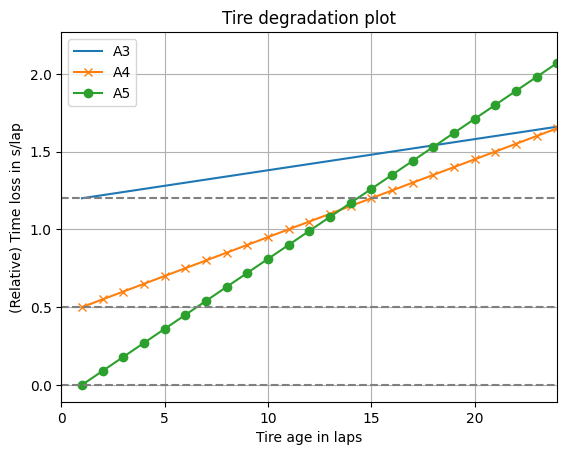

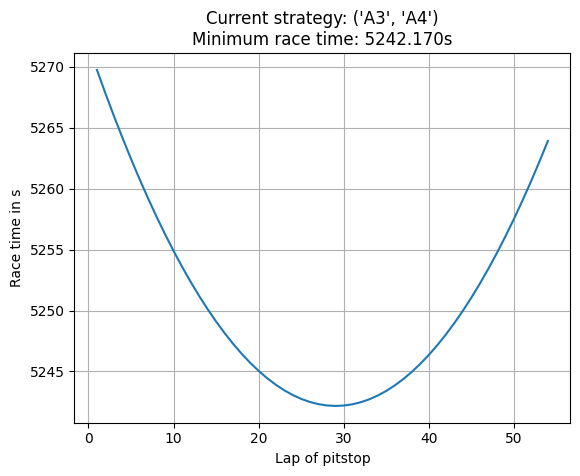

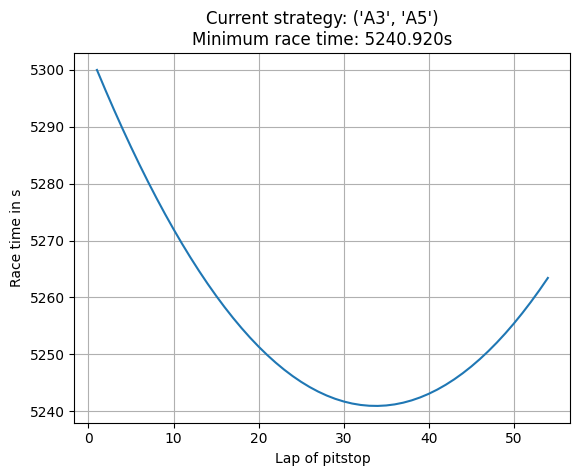

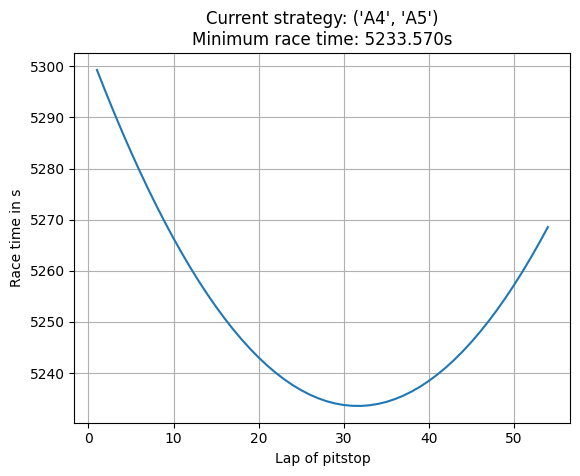

In [7]:
# basic tire degradation plot ----------------------------------------------------------------------------------
stint_length = 25

t_c1_degr = helper_funcs.src.calc_tire_degradation. \
    calc_tire_degradation(tire_age_start=0,
                          stint_length=stint_length,
                          compound=pars_in_['available_compounds'][0],
                          tire_pars=pars_in_['driver_pars']["tire_pars"])

t_c2_degr = helper_funcs.src.calc_tire_degradation. \
    calc_tire_degradation(tire_age_start=0,
                          stint_length=stint_length,
                          compound=pars_in_['available_compounds'][1],
                          tire_pars=pars_in_['driver_pars']["tire_pars"])

t_c3_degr = helper_funcs.src.calc_tire_degradation. \
    calc_tire_degradation(tire_age_start=0,
                          stint_length=stint_length,
                          compound=pars_in_['available_compounds'][2],
                          tire_pars=pars_in_['driver_pars']["tire_pars"])

# plot
fig = plt.figure()
ax = fig.gca()

laps_tmp_ = np.arange(1, stint_length + 1)
ax.plot(laps_tmp_, t_c1_degr)
ax.plot(laps_tmp_, t_c2_degr, 'x-')
ax.plot(laps_tmp_, t_c3_degr, 'o-')

x_min = 0
x_max = laps_tmp_[-1] - 1
ax.set_xlim(left=x_min, right=x_max)
plt.hlines((t_c1_degr[0], t_c2_degr[0], t_c3_degr[0]), x_min, x_max, color='grey', linestyle='--')

# set title and axis labels
plt.legend(pars_in_['available_compounds'])
plt.title('Tire degradation plot')
plt.ylabel('(Relative) Time loss in s/lap')
plt.xlabel('Tire age in laps')

plt.grid()
plt.show()

# plot 1 stop strategies ---------------------------------------------------------------------------------------
if not sim_opts_["use_qp"]:
    for cur_comp_strat_ in t_race_full_factorial_[1]:
        fig = plt.figure()
        ax = fig.gca()

        laps_tmp_ = np.arange(1, pars_in_['race_pars']["tot_no_laps"] + 1)
        # -1 as race must not be finished in pit
        ax.plot(laps_tmp_[:-1], t_race_full_factorial_[1][cur_comp_strat_])

        t_race_min = np.amin(t_race_full_factorial_[1][cur_comp_strat_])
        plt.title('Current strategy: ' + str(cur_comp_strat_) + '\nMinimum race time: %.3fs' % t_race_min)
        plt.xlabel('Lap of pitstop')
        plt.ylabel('Race time in s')

        plt.grid()
        plt.show()

    if sim_opts_["max_no_pitstops"] > 2:
        print('INFO: Plotting of strategies with more than 2 stops is not possible!')


Train RL agent:

In [64]:
# ONE ITERATION TRAIN (for checkpoint testing)
import os
import pickle
import shutil

import numpy as np
import tensorflow as tf
from tf_agents.environments import tf_py_environment
from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

import machine_learning_rl_training
import racesim


# ----------------------------------------------------------------------------------------------------------------------
# USER INPUT -----------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

# environment parameters
race = "Shanghai_2019"  # set race (see racesim/input/parameters for possible races)
# VSE type for other drivers: 'basestrategy', 'realstrategy', 'supervised', 'reinforcement' (if already available),
# 'multi_agent' (if VSE should learn for all drivers at once)
vse_others = "basestrategy"
mcs_pars_file = "pars_mcs.ini"  # parameter file for Monte Carlo parameters

# hyperparameters
num_iterations = 1
replay_buffer_max_length = 200_000
initial_collect_steps = 200
collect_steps_per_iteration = 1

fc_layer_params = (64, 64,)
batch_size = 64
learning_rate = 1e-3
gamma = 1.0  # discount rate
n_step_update = 1
target_update_period = 1
dueling_q_net = False

# training options
log_interval = 100_000
eval_interval = 50_000
num_eval_episodes = 100

# postprocessing (currently not implemented for multi-agent environment)
calculate_final_positions = False  # activate or deactivate evaluation after training
num_races_postproc = 10_000
# VSE type for other drivers: 'basestrategy', 'realstrategy', 'supervised', 'reinforcement' (if already available)
vse_others_postproc = "basestrategy"


# ----------------------------------------------------------------------------------------------------------------------
# CHECK USER INPUT -----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

if vse_others == "multi_agent" and calculate_final_positions:
    print("WARNING: Evaluation of trained strategy is currently not implemented for the multi-agent environment!"
          " Setting calculate_final_positions = False!")
    calculate_final_positions = False

# ----------------------------------------------------------------------------------------------------------------------
# CHECK FOR WET RACE ---------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

# create race parameter file name
race_pars_file = 'pars_%s.ini' % race

# load parameter file
pars_in = racesim.src.import_pars.import_pars(use_print=False,
                                              use_vse=False,
                                              race_pars_file=race_pars_file,
                                              mcs_pars_file=mcs_pars_file)[0]

# loop through drivers and check for intermediate or wet tire compounds in real race
for driver in pars_in["driver_pars"]:
    if any([True if strat[1] in ["I", "W"] else False for strat in pars_in["driver_pars"][driver]["strategy_info"]]):
        raise RuntimeError("Cannot train for current race %s because it was a (partly) wet race!" % race)

# ----------------------------------------------------------------------------------------------------------------------
# ENVIRONMENT ----------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

if vse_others == 'multi_agent':
    train_py_env = machine_learning_rl_training.src.rl_environment_multi_agent.\
        RaceSimulation(race_pars_file=race_pars_file,
                       mcs_pars_file=mcs_pars_file,
                       use_prob_infl=True,
                       create_rand_events=True)
    eval_py_env = machine_learning_rl_training.src.rl_environment_multi_agent. \
        RaceSimulation(race_pars_file=race_pars_file,
                       mcs_pars_file=mcs_pars_file,
                       use_prob_infl=True,
                       create_rand_events=True)
else:
    train_py_env = machine_learning_rl_training.src.rl_environment_single_agent. \
        RaceSimulation(race_pars_file=race_pars_file,
                       mcs_pars_file=mcs_pars_file,
                       vse_type=vse_others,
                       use_prob_infl=True,
                       create_rand_events=True)
    eval_py_env = machine_learning_rl_training.src.rl_environment_single_agent \
        .RaceSimulation(race_pars_file=race_pars_file,
                        mcs_pars_file=mcs_pars_file,
                        vse_type=vse_others,
                        use_prob_infl=True,
                        create_rand_events=True)

train_tf_env = tf_py_environment.TFPyEnvironment(environment=train_py_env)
eval_tf_env = tf_py_environment.TFPyEnvironment(environment=eval_py_env)

print('INFO: Race: %s, strategy of other drivers: %s' % (race, vse_others))

if train_py_env.batched:
    print('INFO: Batched environment:', train_py_env.batched(), 'batch size:', train_py_env.batch_size)

print('INFO: Observation spec:', train_py_env.time_step_spec().observation)
print('INFO: Action spec:', train_py_env.action_spec())


# ----------------------------------------------------------------------------------------------------------------------
# DQN-AGENT ------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

q_net = q_network.QNetwork(input_tensor_spec=train_tf_env.observation_spec(),
                           action_spec=train_tf_env.action_spec(),
                           fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
global_step = tf.compat.v1.train.get_or_create_global_step()

# train_step_counter = tf.Variable(0)
boltzmann_fn = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1.0,
                                                             decay_steps=num_iterations,
                                                             end_learning_rate=0.01)

agent = dqn_agent.DqnAgent(time_step_spec=train_tf_env.time_step_spec(),
                           action_spec=train_tf_env.action_spec(),
                           q_network=q_net,
                           optimizer=optimizer,
                           n_step_update=n_step_update,
                           target_update_period=target_update_period,
                           td_errors_loss_fn=common.element_wise_squared_loss,
                           gamma=gamma,
                           train_step_counter=global_step)
agent.initialize()


# ----------------------------------------------------------------------------------------------------------------------
# POLICIES -------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(time_step_spec=train_tf_env.time_step_spec(),
                                                action_spec=train_tf_env.action_spec())


# ----------------------------------------------------------------------------------------------------------------------
# REPLAY BUFFER --------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(data_spec=agent.collect_data_spec,
                                                               batch_size=train_tf_env.batch_size,
                                                               max_length=replay_buffer_max_length)


# ----------------------------------------------------------------------------------------------------------------------
# DATA COLLECTION ------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

def collect_step(env: tf_py_environment.TFPyEnvironment, policy, buffer):
    time_step_ = env.current_time_step()
    action_step = policy.action(time_step_)
    next_time_step = env.step(action=action_step.action)
    traj = trajectory.from_transition(time_step=time_step_,
                                      action_step=action_step,
                                      next_time_step=next_time_step)

    # add trajectory to the replay buffer
    buffer.add_batch(traj)


def collect_data(env: tf_py_environment.TFPyEnvironment, policy, buffer, steps: int):
    for _ in range(steps):
        collect_step(env=env, policy=policy, buffer=buffer)


collect_data(env=train_tf_env, policy=random_policy, buffer=replay_buffer, steps=initial_collect_steps)

# debugging info if required
# iter(replay_buffer.as_dataset()).next()

dataset = replay_buffer.as_dataset(num_parallel_calls=3,
                                   sample_batch_size=batch_size,
                                   num_steps=n_step_update + 1).prefetch(3)

dataset_iterator = iter(dataset)

# debugging info if required
# dataset_iterator.next()


# ----------------------------------------------------------------------------------------------------------------------
# METRICS AND EVALUATION -----------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

def compute_average_return(env: tf_py_environment.TFPyEnvironment,
                           policy,
                           num_episodes: int = 1) -> float:
    total_return = 0.0

    for _ in range(num_episodes):
        time_step_ = env.reset()
        episode_return = 0.0

        while not any(time_step_.is_last()):
            action_step = policy.action(time_step_)
            time_step_ = env.step(action=action_step.action)
            episode_return += np.mean(time_step_.reward)

        total_return += episode_return

    average_return = total_return / num_episodes

    return average_return


# ----------------------------------------------------------------------------------------------------------------------
# TRAINING THE AGENT ---------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

print("INFO: Starting training...")

# (optional) optimize by wrapping some of the code in a graph using TF function
agent.train = common.function(agent.train)

# reset the train step
agent.train_step_counter.assign(0)

# evaluate the agent's policy once before training
avg_return = compute_average_return(env=eval_tf_env, policy=eval_policy, num_episodes=num_eval_episodes)
print("INFO: Evaluated the agent's policy once before the training, average return: %.3f" % avg_return)

for _ in range(num_iterations):
    # collect a few steps using collect_policy and save them to the replay buffer
    for _ in range(collect_steps_per_iteration):
        collect_step(env=train_tf_env, policy=collect_policy, buffer=replay_buffer)

    # sample a batch of data from the buffer and update the agent's network
    experience = next(dataset_iterator)[0]
    train_loss = agent.train(experience=experience).loss

    step = int(agent.train_step_counter.numpy())

    if step % log_interval == 0:
        print('INFO: Step %i, loss %.3f' % (step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_average_return(env=eval_tf_env, policy=eval_policy, num_episodes=num_eval_episodes)
        print('INFO: Step %i, average return %.3f' % (step, avg_return))

    if (10 * step) % num_iterations == 0:
        # print every 10%
        print('INFO: Training progress: %.0f%%...' % (step / num_iterations * 100.0))


# ----------------------------------------------------------------------------------------------------------------------
# SAVE Q-NETWORK AS TF-LITE --------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

# set paths
tmp_path_ = os.path.join(output_path, 'tmp')

# create folders if not existing
os.makedirs(output_path, exist_ok=True)
os.makedirs(tmp_path_, exist_ok=True)

# set file paths
tmp_file_path_ = os.path.join(tmp_path_, 'q_network_tmp')
preprocessor_file_path_ = os.path.join(output_path, "preprocessor_reinforcement_%s.pkl" % race)
qnet_file_path_ = os.path.join(output_path, "nn_reinforcement_%s.tflite" % race)

# save preprocessor
with open(preprocessor_file_path_, "wb") as fh:
    pickle.dump(train_py_env.cat_preprocessor, fh)


RuntimeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Train the agent.

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

def train_one_iteration():
  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_driver.run()

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  iteration = agent.train_step_counter.numpy()
  print ('iteration: {0} loss: {1}'.format(iteration, train_loss.loss))

Need to checkpoint.

Guide: https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/10_checkpointer_policysaver_tutorial.ipynb#scrollTo=usDm_Wpsl0bu

In [9]:
from tf_agents.policies import policy_saver
from tf_agents.utils import common


checkpoint_dir = os.path.join(output_path, "checkpoint")
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

policy_dir = os.path.join(output_path, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

train_checkpointer.save(global_step)
tf_policy_saver.save(policy_dir)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Restore Checkpoint

In [10]:
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()
global_step

<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=1>

Restore Policy

In [11]:
saved_policy = tf.saved_model.load(policy_dir)
saved_policy

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f850427e3b0>

Convert policy to TFLite

In [22]:
from pathlib import Path
Path(qnet_file_path_).parent.mkdir(exist_ok=True, parents=True)

converter = tf.lite.TFLiteConverter.from_saved_model(policy_dir, signature_keys=["action"])
tflite_policy = converter.convert()

with open(qnet_file_path_, "wb") as f:
  f.write(tflite_policy)

Run inference on TFLite model.

In [49]:
import numpy as np

interpreter = tf.lite.Interpreter(qnet_file_path_)
print(interpreter.get_input_details())
print(interpreter.get_output_details())

policy_runner = interpreter.get_signature_runner()
print(policy_runner._inputs)

[{'name': 'action_0_step_type:0', 'index': 0, 'shape': array([1], dtype=int32), 'shape_signature': array([-1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'action_0_discount:0', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([-1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'action_0_observation:0', 'index': 2, 'shape': array([ 1, 40], dtype=int32), 'shape_signature': array([-1, 40], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension

Evaluate policy

In [32]:
# --------------------------------------------------------------------------------------------------------
# CALCULATE AVERAGE RETURNS --------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import tf_agents.trajectories

import helper_funcs.src.progressbar
from machine_learning_rl_training.src.rl_environment_single_agent import RaceSimulation


def convert_time_step(time_step) -> tf_agents.trajectories.time_step.TimeStep:
    """
    This function converts a given time_step from a Python environment to a TF time_step.
    """

    time_step = tf_agents.trajectories.time_step.\
        TimeStep(step_type=tf.constant([time_step.step_type], dtype=np.int32),
                 reward=tf.constant([time_step.reward], dtype=np.float32),
                 discount=tf.constant([time_step.discount], dtype=np.float32),
                 observation=tf.convert_to_tensor([time_step.observation], dtype=np.float32))

    return time_step


def print_returns_positions(
    py_env: RaceSimulation,
    num_races: int,
    tf_lite_path: str,
    vse_others: str = None):
    """
    This function calculates the returns and final positions with a given q_network as tf-lite over num_races (episodes)
    and distinguishes the returns and positions of races with FCY phases and races without FCY phases.

    vse_others: set VSE type of other drivers -> "supervised" or "reinforcement" or "basestrategy" or "realstrategy"
    """

    if vse_others is not None:
        py_env.vse_type = vse_others
    else:
        vse_others = py_env.vse_type

    # initialize TF lite q-network
    q_net_lite = {"interpreter": tf.lite.Interpreter(model_path=tf_lite_path)}
    q_net_lite["interpreter"].allocate_tensors()
    q_net_lite["input_index"] = q_net_lite["interpreter"].get_input_details()[0]['index']
    q_net_lite["output_index"] = q_net_lite["interpreter"].get_output_details()[0]['index']

    fcy_returns = []
    nofcy_returns = []
    fcy_final_positions = []
    nofcy_final_positions = []

    print('INFO: Evaluating reinforcement VSE by average returns and positions over %i races against %s VSE...'
          % (num_races, vse_others))

    for i in range(num_races):
        time_step = py_env.reset()
        episode_return = 0.0

        while not time_step.is_last():
            # set NN input
            q_net_lite["interpreter"].set_tensor(q_net_lite["input_index"], convert_time_step(time_step).observation)

            # invoke NN
            q_net_lite["interpreter"].invoke()

            # fetch NN output
            action_q = q_net_lite["interpreter"].get_tensor(q_net_lite["output_index"])[0].argmax()

            time_step = py_env.step(action_q)
            episode_return += time_step.reward

        final_position = py_env.race.positions[py_env.race.get_last_compl_lap(py_env.idx_driver), py_env.idx_driver]

        if not py_env.race.fcy_data['phases']:
            nofcy_returns.append(episode_return)
            nofcy_final_positions.append(final_position)
        else:
            fcy_returns.append(episode_return)
            fcy_final_positions.append(final_position)

        helper_funcs.src.progressbar.progressbar(i=i + 1, i_total=num_races, prefix='INFO: Progress:')

    print('RESULT: Average return (total): %.3f (FCY: %.3f, no FCY: %.3f),'
          ' average position (total): %.1f (FCY: %.1f, no FCY: %.1f),'
          ' FCY races: %i, no FCY races: %i'
          % (float(np.mean(fcy_returns + nofcy_returns)),
             float(np.mean(fcy_returns)),
             float(np.mean(nofcy_returns)),
             float(np.mean(fcy_final_positions + nofcy_final_positions)),
             float(np.mean(fcy_final_positions)),
             float(np.mean(nofcy_final_positions)),
             len(fcy_returns),
             len(nofcy_returns)))
    

py_env = RaceSimulation(
    race_pars_file=race_pars_file,
    mcs_pars_file=mcs_pars_file,
    vse_type=vse_others,
    use_prob_infl=True,
    create_rand_events=True)

print_returns_positions(
    py_env=py_env,
    num_races=num_races_postproc,
    tf_lite_path=qnet_file_path_,
    vse_others=vse_others_postproc
)

INFO: Evaluating reinforcement VSE by average returns and positions over 10000 races against reinforcement VSE...


ValueError: ignored

Simulate

In [56]:
from concurrent import futures  # required for parallel computing
import os
import pickle
import time

import numpy as np

import helper_funcs
import racesim
from racesim.src.race_handle import race_handle


def simulate(
    sim_opts: dict,
    race_pars_file: str,
    mcs_pars_file: str,
    vse_paths: list[str]
) -> list:

    # ------------------------------------------------------------------------------------------------------------------
    # INITIALIZATION ---------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    # get repo path
    repo_path = "."

    # create output folders (if not existing)
    output_path = os.path.join(repo_path, "racesim", "output")

    results_path = os.path.join(output_path, "results")
    os.makedirs(results_path, exist_ok=True)

    invalid_dumps_path = os.path.join(output_path, "invalid_dumps")
    os.makedirs(invalid_dumps_path, exist_ok=True)

    testobjects_path = os.path.join(output_path, "testobjects")
    os.makedirs(testobjects_path, exist_ok=True)

    # load parameters
    pars_in, vse_paths = racesim.src.import_pars.import_pars(use_print=sim_opts["use_print"],
                                                             use_vse=sim_opts["use_vse"],
                                                             race_pars_file=race_pars_file,
                                                             mcs_pars_file=mcs_pars_file)

    # check parameters
    racesim.src.check_pars.check_pars(sim_opts=sim_opts, pars_in=pars_in)

    # ------------------------------------------------------------------------------------------------------------------
    # SIMULATION -------------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    # create list containing the simulated race object (single run) or dicts with valid results (multiple runs)
    race_results = []

    # save start time for runtime calculation
    if sim_opts["use_print"]:
        print("INFO: Starting simulations...")
    t_start = time.perf_counter()

    # iteration variables
    no_sim_runs_left = sim_opts["no_sim_runs"]  # counter for the number of races left for simulation
    ctr_invalid = 0                             # counter for the number of simulated races marked as invalid

    # SINGLE PROCESS ---------------------------------------------------------------------------------------------------
    if sim_opts["no_workers"] == 1:

        while no_sim_runs_left > 0:
            # simulate race
            tmp_race_handle = race_handle(pars_in=pars_in,
                                          use_prob_infl=sim_opts['use_prob_infl'],
                                          create_rand_events=sim_opts['create_rand_events'],
                                          vse_paths=vse_paths)
            no_sim_runs_left -= 1

            # CASE 1: result is valid
            if tmp_race_handle.result_status == 0:
                # save race object for later evaluation (single race) or simple race results (MCS)
                if sim_opts["no_sim_runs"] > 1:
                    race_results.append(tmp_race_handle.get_race_results())
                else:
                    race_results.append(tmp_race_handle)

            # CASE 2: result is invalid
            else:
                # increase no_sim_runs_left
                ctr_invalid += 1
                no_sim_runs_left += 1

                # pickle race object for further analysis
                if tmp_race_handle.result_status >= 10 or tmp_race_handle.result_status == -1:
                    cur_time_str = time.strftime("%Y%m%d_%H%M%S")
                    tmp_file_path = os.path.join(invalid_dumps_path, cur_time_str + "_invalid_race_%i_%i.pkl"
                                                 % (ctr_invalid, tmp_race_handle.result_status))

                    with open(tmp_file_path, 'wb') as fh:
                        pickle.dump(tmp_race_handle, fh)

            # print progressbar
            if sim_opts["use_print"]:
                helper_funcs.src.progressbar.progressbar(i=sim_opts["no_sim_runs"] - no_sim_runs_left,
                                                         i_total=sim_opts["no_sim_runs"],
                                                         prefix="INFO: Simulation progress:")

    # MULTIPLE PROCESSES -----------------------------------------------------------------------------------------------
    else:
        # set maximum number of jobs in the waiting queue at the same time -> limits RAM usage
        max_no_concurrent_jobs = 200

        # create executor instance (pool of processes available for parallel calculations)
        with futures.ProcessPoolExecutor(max_workers=sim_opts["no_workers"]) as executor:

            while no_sim_runs_left > 0:
                # reset job queue (list containing current simulation jobs)
                job_queue = []

                # submit simulations to the waiting queue of the executor instance as long as we have races left for
                # simulation and the job queue is not full
                while len(job_queue) <= max_no_concurrent_jobs and no_sim_runs_left > 0:
                    job_queue.append(executor.submit(race_handle,
                                                     pars_in,
                                                     sim_opts['use_prob_infl'],
                                                     sim_opts['create_rand_events'],
                                                     vse_paths))
                    no_sim_runs_left -= 1

                # collect results as soon as they are available
                for job_handle in futures.as_completed(job_queue):
                    tmp_race_handle = job_handle.result()

                    # CASE 1: result is valid
                    if tmp_race_handle.result_status == 0:
                        # save race object for later evaluation (single race) or simple race results (MCS)
                        if sim_opts["no_sim_runs"] > 1:
                            race_results.append(tmp_race_handle.get_race_results())
                        else:
                            race_results.append(tmp_race_handle)

                    # CASE 2: result is invalid
                    else:
                        # increase no_sim_runs_left
                        ctr_invalid += 1
                        no_sim_runs_left += 1

                        # pickle race object for further analysis
                        if tmp_race_handle.result_status >= 10 or tmp_race_handle.result_status == -1:
                            cur_time_str = time.strftime("%Y%m%d_%H%M%S")
                            tmp_file_path = os.path.join(invalid_dumps_path, cur_time_str + "_invalid_race_%i_%i.pkl"
                                                         % (ctr_invalid, tmp_race_handle.result_status))

                            with open(tmp_file_path, 'wb') as fh:
                                pickle.dump(tmp_race_handle, fh)

                # print progressbar
                if sim_opts["use_print"]:
                    helper_funcs.src.progressbar.progressbar(i=sim_opts["no_sim_runs"] - no_sim_runs_left,
                                                             i_total=sim_opts["no_sim_runs"],
                                                             prefix="INFO: Simulation progress:")

    # print number of invalid races
    if sim_opts["use_print"]:
        print("INFO: There were %i invalid races!" % ctr_invalid)

    # print runtime into console window
    if sim_opts["use_print"]:
        runtime = time.perf_counter() - t_start
        print("INFO: Simulation runtime: {:.3f}s ({:.3f}ms per race)".format(runtime,
                                                                             runtime / sim_opts["no_sim_runs"] * 1000))

    # ------------------------------------------------------------------------------------------------------------------
    # POSTPROCESSING ---------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    if sim_opts["use_print"]:
        print("INFO: Postprocessing in progress...")

    # SINGLE RACE ------------------------------------------------------------------------------------------------------
    if sim_opts["no_sim_runs"] == 1:
        race_results[0].check_valid_result()

        if sim_opts["use_print_result"]:
            race_results[0].print_result()
            # race_results[0].print_details()

        if sim_opts["use_plot"]:
            # race_results[0].plot_laptimes()
            # race_results[0].plot_positions()
            # race_results[0].plot_racetime_diffto_refdriver(1)
            # race_results[0].plot_raceprogress_over_racetime()

            laps_simulated = race_results[0].cur_lap
            t_race_winner = np.sort(race_results[0].racetimes[laps_simulated, :])[0]
            race_results[0].plot_racetime_diffto_reflaptime(ref_laptime=t_race_winner / laps_simulated)

        # evaluation
        # race_results[0].print_race_standings(racetime=2520.2)

        # save lap times, race times and positions to csv files
        race_results[0].export_results_as_csv(results_path=results_path)

        # pickle race object for possible CI testing
        result_objects_file_path = os.path.join(testobjects_path, "testobj_racesim_%s_%i.pkl"
                                                % (pars_in["track_pars"]["name"], pars_in["race_pars"]["season"]))
        with open(result_objects_file_path, 'wb') as fh:
            pickle.dump(race_results[0], fh)

    # MULTIPLE RACES ---------------------------------------------------------------------------------------------------
    else:
        # plot histograms
        racesim.src.mcs_analysis.mcs_analysis(race_results=race_results,
                                              use_print_result=sim_opts["use_print_result"],
                                              use_plot=sim_opts["use_plot"])

    if sim_opts["use_print"]:
        print("INFO: Simulation finished successfully!")

    return race_results  # return required in case of CI testing


# ------------------------------------------------------------------------------------------------------------------
# USER INPUT -------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

# set race parameter file names
race_pars_file_ = 'pars_Spielberg_2019.ini'
mcs_pars_file_ = 'pars_mcs.ini'

# set simulation options
# use_prob_infl:        activates probabilistic influences within the race simulation -> lap times, pit stop
#                       durations, race start performance
# create_rand_events:   activates the random creation of FCY (full course yellow) phases and retirements in the race
#                       simulation -> they will only be created if the according entries in the parameter file
#                       contain empty lists, otherwise the file entries are used
# use_vse:              determines if the VSE (virtual strategy engineer) is used to take tire change decisions
#                       -> the VSE type is defined in the parameter file (VSE_PARS)
# no_sim_runs:          number of (valid) races to simulate
# no_workers:           defines number of workers for multiprocess calculations, 1 for single process, >1 for
#                       multi-process (you can use print(multiprocessing.cpu_count()) to determine the max. number)
# use_print:            set if prints to console should be used or not (does not suppress hints/warnings)
# use_print_result:     set if result should be printed to console or not
# use_plot:             set if plotting should be used or not
sim_opts_ = {
    "use_prob_infl": False,
    "create_rand_events": False,
    "use_vse": False,
    "no_sim_runs": 1,
    "no_workers": 1,
    "use_print": True,
    "use_print_result": True,
    "use_plot": False
}

# ------------------------------------------------------------------------------------------------------------------
# SIMULATION CALL --------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

main(sim_opts=sim_opts_,
      race_pars_file=race_pars_file_,
      mcs_pars_file=mcs_pars_file_)

INFO: Loading race parameters...
INFO: Loading MCS parameters...
INFO: Checking user input...
INFO: FCY phases for the race simulation were set as follows: []
INFO: Retirements for the race simulation were set as follows: []
INFO: Starting simulations...
INFO: Simulation progress: |██████████████████████████████████████████████████| 100.0% 
INFO: There were 0 invalid races!
INFO: Simulation runtime: 0.160s (160.429ms per race)
INFO: Postprocessing in progress...
RESULT: Simulation result:
     pos  carno   t_race    gap    int  best_t_lap  no_laps status                                  strategy_info
LEC    1     16 4903.682  0.000  0.000      68.154       71      F                          [0, 'A6'], [22, 'A3']
VER    2     33 4914.647 10.965 10.965      68.517       71      F                          [0, 'A4'], [31, 'A3']
BOT    3     77 4940.021 36.339 25.375      68.919       71      F                          [0, 'A4'], [21, 'A3']
HAM    4     44 4940.521 36.839  0.500      68.510

In [59]:
from pprint import pprint

# load parameters
print(f"{sim_opts_=}")
print(f"{race_pars_file_=}")
print(f"{mcs_pars_file_=}")
pars_in, _ = racesim.src.import_pars.import_pars(
    use_print=sim_opts_["use_print"],
    use_vse=sim_opts_["use_vse"],
    race_pars_file=race_pars_file_,
    mcs_pars_file=mcs_pars_file_
)
print(f"{pars_in=}")
print(f"{vse_paths=}")

pprint(vse_paths)

sim_opts_={'use_prob_infl': False, 'create_rand_events': False, 'use_vse': False, 'no_sim_runs': 1, 'no_workers': 1, 'use_print': True, 'use_print_result': True, 'use_plot': False}
race_pars_file_='pars_Spielberg_2019.ini'
mcs_pars_file_='pars_mcs.ini'
INFO: Loading race parameters...
INFO: Loading MCS parameters...
pars_in={'race_pars': {'season': 2019, 'tot_no_laps': 71, 'min_t_dist': 0.5, 'min_t_dist_sc': 0.8, 't_duel': 0.3, 't_overtake_loser': 0.3, 'use_drs': True, 'drs_window': 1.0, 'drs_allow_lap': 3, 'drs_sc_delay': 2, 'participants': ['HAM', 'RIC', 'MAG', 'HUL', 'KVY', 'RAI', 'VET', 'BOT', 'PER', 'GRO', 'SAI', 'VER', 'GIO', 'STR', 'GAS', 'LEC', 'NOR', 'ALB', 'RUS', 'KUB']}, 'monte_carlo_pars': {'min_dist_sc': 1.5, 'min_dist_vsc': 1.5, 'ref_driver': 'VER', 'p_sc_quant': [0.455, 0.413, 0.099, 0.033], 'p_sc_start': [0.364, 0.136, 0.136, 0.08, 0.193, 0.091], 'p_sc_duration': [0.0, 0.182, 0.25, 0.227, 0.193, 0.057, 0.068, 0.023, 0.0, 0.0], 'p_vsc_aft_failure': 0.227, 'p_vsc_duration

In [52]:
from concurrent import futures  # required for parallel computing
import os
import pickle
import time

import numpy as np

import helper_funcs
import racesim
from racesim.src.race_handle import race_handle


def main(sim_opts: dict, race_pars_file: str, mcs_pars_file: str) -> list:

    # ------------------------------------------------------------------------------------------------------------------
    # INITIALIZATION ---------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    # get repo path
    repo_path = "."

    # create output folders (if not existing)
    output_path = os.path.join(repo_path, "racesim", "output")

    results_path = os.path.join(output_path, "results")
    os.makedirs(results_path, exist_ok=True)

    invalid_dumps_path = os.path.join(output_path, "invalid_dumps")
    os.makedirs(invalid_dumps_path, exist_ok=True)

    testobjects_path = os.path.join(output_path, "testobjects")
    os.makedirs(testobjects_path, exist_ok=True)

    # load parameters
    pars_in, vse_paths = racesim.src.import_pars.import_pars(use_print=sim_opts["use_print"],
                                                             use_vse=sim_opts["use_vse"],
                                                             race_pars_file=race_pars_file,
                                                             mcs_pars_file=mcs_pars_file)

    # check parameters
    racesim.src.check_pars.check_pars(sim_opts=sim_opts, pars_in=pars_in)

    # ------------------------------------------------------------------------------------------------------------------
    # SIMULATION -------------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    # create list containing the simulated race object (single run) or dicts with valid results (multiple runs)
    race_results = []

    # save start time for runtime calculation
    if sim_opts["use_print"]:
        print("INFO: Starting simulations...")
    t_start = time.perf_counter()

    # iteration variables
    no_sim_runs_left = sim_opts["no_sim_runs"]  # counter for the number of races left for simulation
    ctr_invalid = 0                             # counter for the number of simulated races marked as invalid

    # SINGLE PROCESS ---------------------------------------------------------------------------------------------------
    if sim_opts["no_workers"] == 1:

        while no_sim_runs_left > 0:
            # simulate race
            tmp_race_handle = race_handle(pars_in=pars_in,
                                          use_prob_infl=sim_opts['use_prob_infl'],
                                          create_rand_events=sim_opts['create_rand_events'],
                                          vse_paths=vse_paths)
            no_sim_runs_left -= 1

            # CASE 1: result is valid
            if tmp_race_handle.result_status == 0:
                # save race object for later evaluation (single race) or simple race results (MCS)
                if sim_opts["no_sim_runs"] > 1:
                    race_results.append(tmp_race_handle.get_race_results())
                else:
                    race_results.append(tmp_race_handle)

            # CASE 2: result is invalid
            else:
                # increase no_sim_runs_left
                ctr_invalid += 1
                no_sim_runs_left += 1

                # pickle race object for further analysis
                if tmp_race_handle.result_status >= 10 or tmp_race_handle.result_status == -1:
                    cur_time_str = time.strftime("%Y%m%d_%H%M%S")
                    tmp_file_path = os.path.join(invalid_dumps_path, cur_time_str + "_invalid_race_%i_%i.pkl"
                                                 % (ctr_invalid, tmp_race_handle.result_status))

                    with open(tmp_file_path, 'wb') as fh:
                        pickle.dump(tmp_race_handle, fh)

            # print progressbar
            if sim_opts["use_print"]:
                helper_funcs.src.progressbar.progressbar(i=sim_opts["no_sim_runs"] - no_sim_runs_left,
                                                         i_total=sim_opts["no_sim_runs"],
                                                         prefix="INFO: Simulation progress:")

    # MULTIPLE PROCESSES -----------------------------------------------------------------------------------------------
    else:
        # set maximum number of jobs in the waiting queue at the same time -> limits RAM usage
        max_no_concurrent_jobs = 200

        # create executor instance (pool of processes available for parallel calculations)
        with futures.ProcessPoolExecutor(max_workers=sim_opts["no_workers"]) as executor:

            while no_sim_runs_left > 0:
                # reset job queue (list containing current simulation jobs)
                job_queue = []

                # submit simulations to the waiting queue of the executor instance as long as we have races left for
                # simulation and the job queue is not full
                while len(job_queue) <= max_no_concurrent_jobs and no_sim_runs_left > 0:
                    job_queue.append(executor.submit(race_handle,
                                                     pars_in,
                                                     sim_opts['use_prob_infl'],
                                                     sim_opts['create_rand_events'],
                                                     vse_paths))
                    no_sim_runs_left -= 1

                # collect results as soon as they are available
                for job_handle in futures.as_completed(job_queue):
                    tmp_race_handle = job_handle.result()

                    # CASE 1: result is valid
                    if tmp_race_handle.result_status == 0:
                        # save race object for later evaluation (single race) or simple race results (MCS)
                        if sim_opts["no_sim_runs"] > 1:
                            race_results.append(tmp_race_handle.get_race_results())
                        else:
                            race_results.append(tmp_race_handle)

                    # CASE 2: result is invalid
                    else:
                        # increase no_sim_runs_left
                        ctr_invalid += 1
                        no_sim_runs_left += 1

                        # pickle race object for further analysis
                        if tmp_race_handle.result_status >= 10 or tmp_race_handle.result_status == -1:
                            cur_time_str = time.strftime("%Y%m%d_%H%M%S")
                            tmp_file_path = os.path.join(invalid_dumps_path, cur_time_str + "_invalid_race_%i_%i.pkl"
                                                         % (ctr_invalid, tmp_race_handle.result_status))

                            with open(tmp_file_path, 'wb') as fh:
                                pickle.dump(tmp_race_handle, fh)

                # print progressbar
                if sim_opts["use_print"]:
                    helper_funcs.src.progressbar.progressbar(i=sim_opts["no_sim_runs"] - no_sim_runs_left,
                                                             i_total=sim_opts["no_sim_runs"],
                                                             prefix="INFO: Simulation progress:")

    # print number of invalid races
    if sim_opts["use_print"]:
        print("INFO: There were %i invalid races!" % ctr_invalid)

    # print runtime into console window
    if sim_opts["use_print"]:
        runtime = time.perf_counter() - t_start
        print("INFO: Simulation runtime: {:.3f}s ({:.3f}ms per race)".format(runtime,
                                                                             runtime / sim_opts["no_sim_runs"] * 1000))

    # ------------------------------------------------------------------------------------------------------------------
    # POSTPROCESSING ---------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    if sim_opts["use_print"]:
        print("INFO: Postprocessing in progress...")

    # SINGLE RACE ------------------------------------------------------------------------------------------------------
    if sim_opts["no_sim_runs"] == 1:
        race_results[0].check_valid_result()

        if sim_opts["use_print_result"]:
            race_results[0].print_result()
            # race_results[0].print_details()

        if sim_opts["use_plot"]:
            # race_results[0].plot_laptimes()
            # race_results[0].plot_positions()
            # race_results[0].plot_racetime_diffto_refdriver(1)
            # race_results[0].plot_raceprogress_over_racetime()

            laps_simulated = race_results[0].cur_lap
            t_race_winner = np.sort(race_results[0].racetimes[laps_simulated, :])[0]
            race_results[0].plot_racetime_diffto_reflaptime(ref_laptime=t_race_winner / laps_simulated)

        # evaluation
        # race_results[0].print_race_standings(racetime=2520.2)

        # save lap times, race times and positions to csv files
        race_results[0].export_results_as_csv(results_path=results_path)

        # pickle race object for possible CI testing
        result_objects_file_path = os.path.join(testobjects_path, "testobj_racesim_%s_%i.pkl"
                                                % (pars_in["track_pars"]["name"], pars_in["race_pars"]["season"]))
        with open(result_objects_file_path, 'wb') as fh:
            pickle.dump(race_results[0], fh)

    # MULTIPLE RACES ---------------------------------------------------------------------------------------------------
    else:
        # plot histograms
        racesim.src.mcs_analysis.mcs_analysis(race_results=race_results,
                                              use_print_result=sim_opts["use_print_result"],
                                              use_plot=sim_opts["use_plot"])

    if sim_opts["use_print"]:
        print("INFO: Simulation finished successfully!")

    return race_results  # return required in case of CI testing


# ------------------------------------------------------------------------------------------------------------------
# USER INPUT -------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

# set race parameter file names
race_pars_file_ = 'pars_Spielberg_2019_custom.ini'
mcs_pars_file_ = 'pars_mcs.ini'

# set simulation options
# use_prob_infl:        activates probabilistic influences within the race simulation -> lap times, pit stop
#                       durations, race start performance
# create_rand_events:   activates the random creation of FCY (full course yellow) phases and retirements in the race
#                       simulation -> they will only be created if the according entries in the parameter file
#                       contain empty lists, otherwise the file entries are used
# use_vse:              determines if the VSE (virtual strategy engineer) is used to take tire change decisions
#                       -> the VSE type is defined in the parameter file (VSE_PARS)
# no_sim_runs:          number of (valid) races to simulate
# no_workers:           defines number of workers for multiprocess calculations, 1 for single process, >1 for
#                       multi-process (you can use print(multiprocessing.cpu_count()) to determine the max. number)
# use_print:            set if prints to console should be used or not (does not suppress hints/warnings)
# use_print_result:     set if result should be printed to console or not
# use_plot:             set if plotting should be used or not
sim_opts_ = {"use_prob_infl": False,
              "create_rand_events": False,
              "use_vse": True,
              "no_sim_runs": 1,
              "no_workers": 1,
              "use_print": True,
              "use_print_result": True,
              "use_plot": False}

# ------------------------------------------------------------------------------------------------------------------
# SIMULATION CALL --------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

main(sim_opts=sim_opts_,
      race_pars_file=race_pars_file_,
      mcs_pars_file=mcs_pars_file_)

INFO: Loading race parameters...
INFO: Loading MCS parameters...
INFO: Checking user input...
INFO: FCY phases for the race simulation were set as follows: []
INFO: Retirements for the race simulation were set as follows: []
INFO: Using VSE (virtual strategy engineer) to take tire change decisions!
INFO: Starting simulations...
INFO: Simulation progress: |██████████████████████████████████████████████████| 100.0% 
INFO: There were 0 invalid races!
INFO: Simulation runtime: 0.357s (356.920ms per race)
INFO: Postprocessing in progress...
RESULT: Simulation result:
     pos  carno   t_race    gap    int  best_t_lap  no_laps status                                             strategy_info
VER    1     33 4911.532  0.000  0.000      67.516       71      F                                     [0, 'A4'], [65, 'A3']
LEC    2     16 4926.854 15.322 15.322      67.487       71      F                         [0, 'A6'], [28, 'A3'], [57, 'A6']
BOT    3     77 4936.757 25.226  9.904      68.003      